# Connect to Trader Workstation 
** from Interactive Brokers (testing use port 7497 for paper trading account.) **

In [1]:
# common imports
import numpy as np
import os

from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=3)

<IB connected to 127.0.0.1:7497 clientId=3>

Test for connection

In [2]:
ib.isConnected()

True

Select the Stock we wish to model. Data pulled using Interactive Brokers API.

In [3]:

contract = Stock('TSLA', 'SMART', 'USD')
# shows date of first available historical data (how far back we can model).
ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)

datetime.datetime(2010, 6, 29, 8, 0)

In [39]:
# TRADES HISTORICAL_VOLATILITY OPTION_IMPLIED_VOLATILITY. 90 day sample

In [4]:
trade_data = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='90 D',
        barSizeSetting='1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

In [17]:
trade_data[1]

np.save('tsla_trades_90day', trade_data)

 Option implied volitiilty data 

In [7]:
option_implied_vol = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='90 D',
        barSizeSetting='1 min',
        whatToShow='OPTION_IMPLIED_VOLATILITY',
        useRTH=True,
        formatDate=1)

In [18]:
option_implied_vol[0]
print(len(trade_data))
print(trade_data[1])
print(option_implied_vol[1])
# trade_data[0]
np.save('tsla_opt_vol_90day', option_implied_vol)

34911
BarData(date=datetime.datetime(2018, 5, 8, 6, 31), open=301.67, high=302.44, low=301.67, close=302.08, volume=385, barCount=225, average=302.058)
BarData(date=datetime.datetime(2018, 5, 8, 6, 31), open=0.42740525, high=0.43219935, low=0.42740525, close=0.43219935, average=0.43219935)


In [ ]:
trades_back = 

Helper function to ready data

In [19]:
def data_prep(trade_data, option_implied_vol):
    # convert into dataframes 
    df_trades = util.df(trade_data)
    df_optImpVol = util.df(option_implied_vol)
    # remove empty colums (volume, barcount) and rename columns so they dont conflict with Trades
    df_optImpVol.drop(columns=['volume', 'barCount'], inplace=True)
    # Rename cols
    df_optImpVol.rename(index=str, columns={"open": "volOpen", "high":"volHigh", "low":"volLow", "close":"volClose", "average":"volAverage"})
    # Merge datasets
    df_merged = df_trades.merge(df_optImpVol, left_on='date', right_on='date', how='outer')
    #  add new columns and normalize data. 
    #  ROC_min = close_x - open_x / open_x * 100    # Rate of change per minute
    df_merged['ROC_min'] = ( df_merged['close_x'] - df_merged['open_x'] ) / ( df_merged['open_x']  ) 
    #  perMinVol = high_x - low_x / low_x * 100     # intra minute spread volitity
    df_merged['perMinVol'] = ( df_merged['high_x'] - df_merged['low_x'] ) / df_merged['low_x'] 
    # adding 7day rolling mean for price 
    df_merged['rollMean_7day'] = df_merged['close_x'].rolling(2940).mean()
    # drop unwanted columns: open_x, high_x, low_x, average_x, open_y, hight_y, low_y, average_y 
    df_merged.drop(columns=['date','open_x', 'high_x', 'low_x', 'average_x', 'open_y', 'high_y', 'low_y', 'average_y'], inplace=True)
#     # Rename cols
#     df_merged.rename(index=str, columns={"close_x":"price_close", "close_y":"avgMinVol"})
#     df_merged.head(3)
    df_merged.dropna(inplace=True)

    return df_merged



In [20]:
df = data_prep(trade_data, option_implied_vol)
print(df.shape)
print(df.head(3))
# remove the NaN's from rollMean_7day
df = df[2950 : ]
print(df.shape)
print(df.head(3))


(31972, 7)
      close_x  volume  barCount   close_y   ROC_min  perMinVol  rollMean_7day
2939   285.74    49.0      31.0  0.424627  0.000525   0.000735     296.530024
2940   286.04   131.0      72.0  0.424373  0.001225   0.002067     296.524694
2941   285.82    48.0      34.0  0.424373 -0.000420   0.000700     296.519163
(29022, 7)
      close_x  volume  barCount   close_y   ROC_min  perMinVol  rollMean_7day
5889   285.41    68.0      24.0  0.416674  0.000070   0.000806     279.646238
5890   285.65    80.0      38.0  0.416674  0.001402   0.001402     279.646194
5891   285.97   389.0     151.0  0.415753  0.001085   0.001925     279.646296


In [11]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
# dataset = read_csv('/Users/lorinfields/Downloads/pollution.csv', header=0, index_col=0)
dataset = df

values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# # ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print('scaled', scaled[1])
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print('This is reframed.head ', reframed.head())
print('reframed shape', reframed.shape)

/Users/lorinfields/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


scaled [2.4954998e-01 7.3233247e-03 7.8302082e-03 1.7473215e-01 5.3896075e-01
 3.1511240e-02 1.3446808e-04]
This is reframed.head     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.247751   0.006225   0.004945   0.174732   0.511749   0.018123   
2   0.249550   0.007323   0.007830   0.174732   0.538961   0.031511   
3   0.251949   0.035610   0.031115   0.172237   0.532484   0.043267   
4   0.250300   0.013090   0.012776   0.172237   0.491035   0.036180   
5   0.249325   0.010070   0.007418   0.173872   0.502453   0.027559   

   var7(t-1)   var1(t)  
1   0.000135  0.249550  
2   0.000134  0.251949  
3   0.000136  0.250300  
4   0.000137  0.249325  
5   0.000136  0.246102  
reframed shape (29021, 8)


In [12]:
 
# split into train and test sets
values = reframed.values
n_train_min = 25000
print(values.shape)
print(values[0])
train = values[:n_train_min, :]
test = values[n_train_min:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(29021, 8)
[2.4775112e-01 6.2248260e-03 4.9453946e-03 1.7473215e-01 5.1174867e-01
 1.8122775e-02 1.3518333e-04 2.4954998e-01]
(25000, 1, 7) (25000,) (4021, 1, 7) (4021,)


Train on 25000 samples, validate on 4021 samples
Epoch 1/50
 - 3s - loss: 0.0114 - val_loss: 0.0286
Epoch 2/50
 - 1s - loss: 0.0055 - val_loss: 0.0202
Epoch 3/50
 - 1s - loss: 0.0038 - val_loss: 0.0104
Epoch 4/50
 - 1s - loss: 0.0027 - val_loss: 0.0037
Epoch 5/50
 - 1s - loss: 0.0022 - val_loss: 9.5614e-04
Epoch 6/50
 - 1s - loss: 0.0019 - val_loss: 2.0426e-04
Epoch 7/50
 - 1s - loss: 0.0017 - val_loss: 2.9302e-04
Epoch 8/50
 - 1s - loss: 0.0015 - val_loss: 5.9860e-04
Epoch 9/50
 - 1s - loss: 0.0012 - val_loss: 8.0506e-04
Epoch 10/50
 - 1s - loss: 8.5931e-04 - val_loss: 8.4478e-04
Epoch 11/50
 - 1s - loss: 6.2390e-04 - val_loss: 7.5181e-04
Epoch 12/50
 - 1s - loss: 4.5531e-04 - val_loss: 5.8505e-04
Epoch 13/50
 - 1s - loss: 3.4467e-04 - val_loss: 4.0694e-04
Epoch 14/50
 - 1s - loss: 2.7861e-04 - val_loss: 2.7792e-04
Epoch 15/50
 - 1s - loss: 2.4309e-04 - val_loss: 2.3155e-04
Epoch 16/50
 - 1s - loss: 2.2423e-04 - val_loss: 2.5589e-04
Epoch 17/50
 - 1s - loss: 2.1051e-04 - val_loss: 3.0

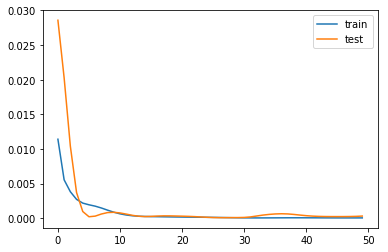

In [13]:
# *** Now we can define and fit our LSTM model.
# We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.
# We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
# The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).
# Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.
# ***
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 


In [14]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_yhat.shape)
print(inv_y.shape)
print(inv_yhat[500])
print(inv_y[500])
runs = len(inv_y)
print(runs)
# if the model predicts the stock is going up it buys $1M a minute worth of shares and sells the following minute.
# if the stock does indeed gain the net is added to total. If it loses the net loss is subtracted 
# from total.
totalGain = 0
totalBuys = 0
for i in range(runs - 1):
    if ((inv_yhat[i + 1] - inv_y[i]) > .3 ):
        shares = 1000000 / inv_y[i]
        gainPerShare = inv_y[i + 1] - inv_y[i] 
        totalGain += shares * gainPerShare
        totalBuys += 1
#         print('gain= ', inv_yhat[i + 1] - inv_y[i])
#         print('% gain= ', ((inv_yhat[i + 1] - inv_y[i]) / inv_y[i]))
              
print('totalGain $', totalGain)
print('totalBuys', totalBuys)
annGain = totalGain * 32.5
print('Annualized gain: $', annGain)
# print('real and proj', inv_y[20], inv_yhat[20])
    
    


Test RMSE: 2.315
(4021,)
(4021,)
301.3004
301.07
4021
totalGain $ -24284.625127618023
totalBuys 3866
Annualized gain: $ -789250.3166475857


In [15]:
# save the trained model for export
# save model to single file
model.save('/Users/lorinfields/Dropbox/Lambda/mlai/iblocal/lstm_model.h5')

In [16]:
ib.disconnect()